### Members
***
+ UID: 805861373, name: Sinya Peng
+ UID: 205928946, name: Yu-Wei Chen
+ UID: 705668757, name: Kuei-Chun Huang

In [1]:
# !pip install matplotlib==3.6.0
# !pip install scikit-learn==1.2.0
# !pip install nltk
# !pip install umap-learn
# !pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image
# !pip install umap-learn[plot]
# !pip install holoviews

# Reference to: https://github.com/lmcinnes/umap/issues/405

In [2]:
import math
import random
import re

from joblib import Memory
from tempfile import mkdtemp
from typing import List

import nltk
import numpy as np
import pandas as pd
import umap.umap_ as umap
import umap.plot

from matplotlib import pyplot as plt
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import preprocessing, metrics
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, 
                             auc,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score, 
                             precision_score, 
                             RocCurveDisplay,
                             recall_score, 
                             roc_curve, 
                            )
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import randomized_svd

In [3]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

SEED = 42
np.random.seed(SEED)
plt.style.use("seaborn-bright")
random.seed(SEED)

[nltk_data] Downloading package punkt to /home/ray080186/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ray080186/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipykernel_29832/1528843050.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


In [4]:
data = pd.read_csv("Project1-Classification.csv", encoding='utf8', engine='python')

In [5]:
data.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


---

### QUESTION 1: Provide answers to the following questions:

#### Overview: How many rows (samples) and columns (features) are present in the dataset?

> Ans: 3150 rows and 8 columns

In [6]:
print(data.shape)

(3150, 8)


#### Histograms: Plot 3 histograms on : 
- (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; 
- (b) The column leaf label – class on the x-axis; 
- (c) The column root label – class on the x-axis.

#### (a)

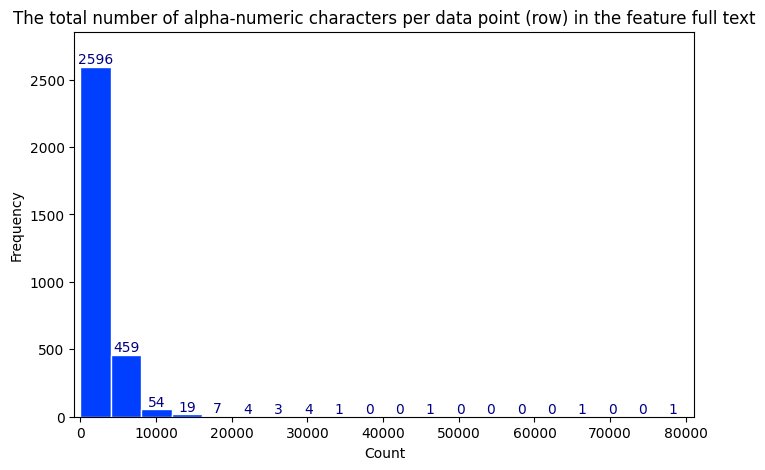

In [7]:
plt.figure(figsize=(8, 5))
values, bins, bars = plt.hist(data['full_text']
                              .str.replace('[^a-zA-Z0-9]', '', regex=True)
                              .str.replace(' ', '')
                              .str.len(), 
                              edgecolor='white', 
                              bins=20)
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("The total number of alpha-numeric characters per data point (row) in the feature full text")
plt.bar_label(bars, fontsize=10, color='navy')
plt.margins(x=0.01, y=0.1)
plt.show()

#### (b)

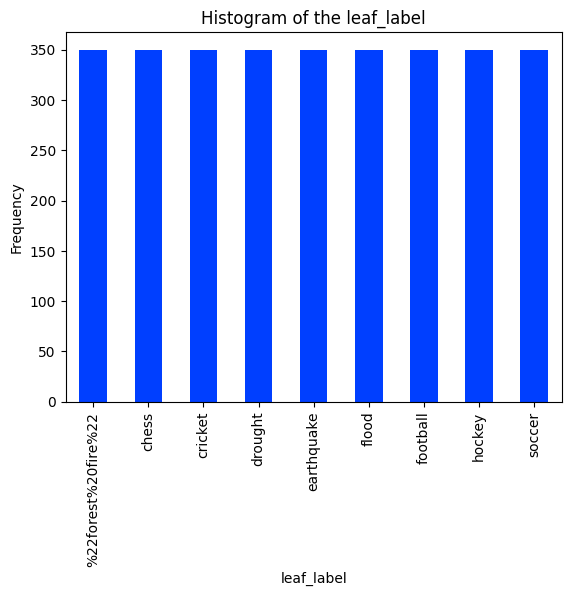

In [8]:
data.groupby(['leaf_label']).count()['root_label'].plot(kind="bar")
plt.title("Histogram of the leaf_label")
plt.ylabel("Frequency")
plt.show()

#### (c)

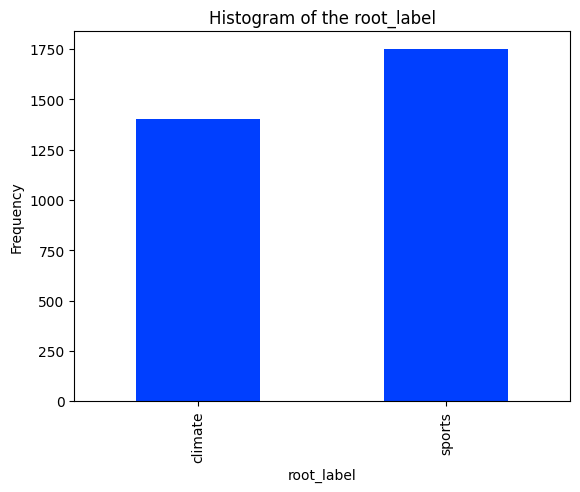

In [9]:
data.groupby(['root_label']).count()['leaf_label'].plot(kind="bar")
plt.title("Histogram of the root_label")
plt.ylabel("Frequency")
plt.show()

#### • Interpret Plots: Provide qualitative interpretations of the histograms.

> Ans: 

> (a) Most of the articles have character lengths within 10000. The frequencies of articles with more than 10000 characters drop significantly. However, we can still observe a maximum count of 80321 characters from one article.

> (b) The counts of article under each leaf label is very balanced. Each leaf label has 350 articles.

> (c) From the root label perspective, "sports" has one more leaf label than "climate". Therefore, "sports" have 350 more articles than "climate" (1750 vs 1400).

---

### QUESTION 2: Report the number of training and testing samples.

> Ans: <br>
> training: 2520 samples <br>
> testing: 630 samples

In [13]:
train, test = train_test_split(data, test_size=0.2)
len(train), len(test)

(2520, 630)

---

### QUESTION 3: Use the following specs to extract features from the textual data:

In [10]:
# only do text-cleaning once
def pos_clean(text):
    # Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
    text = re.sub('[+-]?([0-9]*[.])?[0-9]+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Merge multiple spaces into one space
    text = re.sub(' +', ' ', text)
    return text

def lemmatization(text):
    # Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag
    lemmatizer = WordNetLemmatizer()
    # Reference: https://stackoverflow.com/a/51154991
    # WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
    # Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
    tag_map = {
        'CD':wordnet.NOUN, # cardinal number (one, two)             
        'EX':wordnet.ADV, # existential ‘there’ (there)           
        'IN':wordnet.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':wordnet.ADJ, # adjective (yellow)                  
        'JJR':wordnet.ADJ, # adj., comparative (bigger)          
        'JJS':wordnet.ADJ, # adj., superlative (wildest)                             
        'NN':wordnet.NOUN, # noun, sing. or mass (llama)          
        'NNS':wordnet.NOUN, # noun, plural (llamas)                  
        'NNP':wordnet.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wordnet.NOUN, # proper noun, plural (Carolinas)
        'PDT':wordnet.ADJ, # predeterminer (all, both)              
        'RB':wordnet.ADV, # adverb (quickly, never)            
        'RBR':wordnet.ADV, # adverb, comparative (faster)        
        'RBS':wordnet.ADV, # adverb, superlative (fastest)     
        'RP':wordnet.ADJ, # particle (up, off)
        'VB':wordnet.VERB, # verb base form (eat)
        'VBD':wordnet.VERB, # verb past tense (ate)
        'VBG':wordnet.VERB, # verb gerund (eating)
        'VBN':wordnet.VERB, # verb past participle (eaten)
        'VBP':wordnet.VERB, # verb non-3sg pres (eat)
        'VBZ':wordnet.VERB, # verb 3sg pres (eats)
    }
    tokens = word_tokenize(text)  # Generate list of tokens
    tagged_tokens = pos_tag(tokens)
    text = " ".join([lemmatizer.lemmatize(word.lower(), pos=tag_map.get(tag, "n")) for word, tag in tagged_tokens])
    return text


def stemming(text):
    stemmer = PorterStemmer()
    # Reference: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
    tokens = word_tokenize(text)
    text = " ".join([stemmer.stem(word.lower()) for word in tokens])
    return text

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean_regex = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean_regex, '', texter)
    if texter == " ":
        texter = ""
    return texter

In [11]:
def preprocess_text(method, text):
    text = clean(text)
    text = lemmatization(text) if method == "lemmatization" else stemming(text)
    text = pos_clean(text)
    return text 

In [12]:
from functools import partial

preprocess_lemmatization = partial(preprocess_text, "lemmatization")
preprocess_stemming = partial(preprocess_text, "stemming")

data["full_text_lemma"] = data["full_text"].apply(preprocess_lemmatization)
data["full_text_stem"] = data["full_text"].apply(preprocess_stemming)

In [14]:
# [DONE] Before doing anything, please clean each data sample using the code block provided above...
# [DONE] Use the “english” stopwords of the CountVectorizer
# [DONE] Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
# [DONE] Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag
# [DONE] Use min_df=3

# Use the “english” stopwords of the CountVectorizer and min_df=3
pipe = Pipeline([
    ('count', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer())])

In [15]:
# train
X_train = pipe.fit_transform(train["full_text_lemma"])
X_train.shape

(2520, 14163)

In [16]:
# test
X_test = pipe.transform(test["full_text_lemma"])
X_test.shape

(630, 14163)

#### • What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
> Ans:

> (1) Lemmatization uses a dictionary-based approach and takes into account the context and part of speech of a word to determine its lemma, or base form. This method is more accurate but also more computationally expensive. On the other hand, stemming uses a rule-based approach to remove suffixes from a word, which is less accurate but less computationally expensive.

> (2) Regarding the dictionary size, lemmatization will typically result in a smaller dictionary size because words are reduced to their base forms based on their context and part of speech. Stemming will typically result in a larger dictionary size because it only removes suffixes, which may not always reduce a word to its base form.



####  • min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?
> Ans: A high min_df value will lead to a smaller matrix that only includes words that frequently appear across many documents. However, this may also exclude essential words that appear in fewer documents. On the other hand, a low min_df value will lead to a larger matrix that includes words that appear in fewer documents, but may also include less informative words. As the min_df value increases, the number of words that appear in many documents in the matrix will increase, while the number of words that appear in fewer documents will decrease. Conversely, as the min_df value decreases, the number of words that appear in many documents will decrease while the number of words that appear in fewer documents will increase.


####  • Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
> Ans: Given the provided hint, the whole sentence is input into the Lemmatizer, and the lemmatizer tags the position of every word based on the sentence structure. If using stopwords ahead of the lemmatizer, the word structure is already broken since some words are removed. 

> (1) Therefore, we should perform lemmatizing before removing stopwords in general cases. <br>
> (2) Similarly, perform lemmatizing before removing punctuations. <br>
> (3) Similarly, perform lemmatizing before removing numbers. <br>

####  • Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of $k\times10^3$. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.
> Ans: <br>
> train: (2520, 14163) <br>
> test: (630, 14163) <br>

### QUESTION 4: Reduce the dimensionality of the data using the methods above

#### Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

> Ans: 

> (1) When k goes up, the f(k) change rate decreases. The curve is concave down.

> (2) This is an array of the variance of the data explained by each of the k components. If we sum up the values in the array, they will add up to 1, indicating that the 2000 components together explain ~99% of the variance of the data. The amount of variance explained increases as we add more principal components, where k=10 explains 15%, k=50 explains 31%, k=100 ex, etc, all the way up to 99% explained by all 2000 principal components.

> The concave down suggests that each component will contain less explained variance successively. That is why the figure's change rate decreases when the value of k goes larger.


In [17]:
k_options = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio_cross_k = []
sum_explained_variance_ratio_cross_k = []

for k in k_options:
    lsi = TruncatedSVD(n_components=k, random_state=SEED)
    X_train_LSI = lsi.fit_transform(X_train) 
    explained_variance_ratio_cross_k.append(lsi.explained_variance_ratio_)
    sum_explained_variance_ratio_cross_k.append(lsi.explained_variance_ratio_.sum())


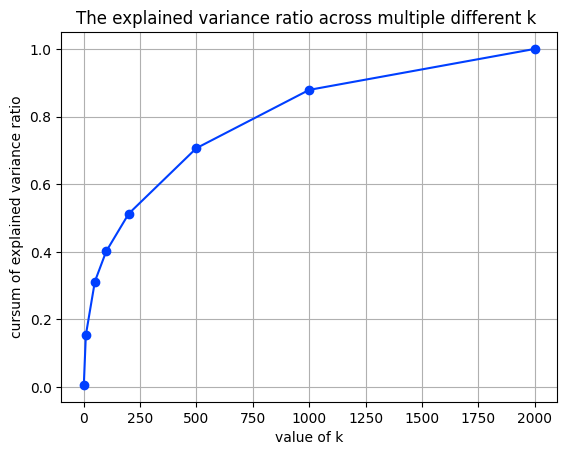

In [18]:
plt.plot(k_options, sum_explained_variance_ratio_cross_k, marker='o')
plt.xlabel("value of k")
plt.ylabel("cursum of explained variance ratio")
plt.title("The explained variance ratio across multiple different k ")
plt.grid()
plt.show()

# Reference to: https://openclassrooms.com/en/courses/5869986-perform-an-exploratory-data-analysis/6172111-analyze-the-results

#### With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the |X−WH|2 in NMF or the |X−U Σ VT|2 in LSI and why?

> Ans:

> Train: <br>
LSI Error: 1677.27888438890438 <br>
NMF Error: 1704.481282101661

> Test: <br>
LSI Error: 400.4524660995262 <br>
NMF Error: 453.8321101647344

> The error in Non-negative Matrix Factorization (NMF) is larger than Latent Semantic Indexing (LSI) due to the added constraints of non-negativity on the matrices W and H in NMF. These constraints restrict the search space, making it more difficult for the algorithm to find the optimal solution. In contrast, LSI has a larger search space and allows for negative values in the matrices, providing more freedom for the algorithm to minimize the error.

In [19]:
lsi = TruncatedSVD(n_components=50, random_state=SEED)
X_train_LSI = lsi.fit_transform(X_train) 

U, sigma, V = randomized_svd(X_train, n_components=50) 
print(f"LSI Error: {np.sum(np.array(X_train - U.dot(np.diag(sigma)).dot(V))**2)}")

nmf_model = NMF(n_components=50, init='random', random_state=SEED)
X_train_NMF = nmf_model.fit_transform(X_train)
H = nmf_model.components_
print(f"NMF Error: {np.sum(np.array(X_train - X_train_NMF.dot(H))**2)}")

# Reference to: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

LSI Error: 1677.2788843889043
NMF Error: 1704.4812821016608


In [20]:
X_test_LSI = lsi.transform(X_test) 
U, sigma, V = randomized_svd(X_test, n_components=50) 
print(f"LSI Error: {np.sum(np.array(X_test - U.dot(np.diag(sigma)).dot(V))**2)}")

X_test_NMF = nmf_model.transform(X_test)
H = nmf_model.components_
print(f"NMF Error: {np.sum(np.array(X_test - X_test_NMF.dot(H))**2)}")

LSI Error: 400.4524660995261
NMF Error: 453.83211016473433


### QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs:

#### – Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

In [21]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train.root_label)
train['root_label_cat'] = label_encoder.transform(train.root_label)
test['root_label_cat'] = label_encoder.transform(test.root_label)

In [22]:
svm_soft = LinearSVC(C=0.0001, random_state=SEED)
svm_hard = LinearSVC(C=1000, random_state=SEED)
svm_hard_100000 = LinearSVC(C=100000, random_state=SEED)

In [23]:
y_pred_soft = svm_soft.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
y_pred_hard = svm_hard.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI) 
y_pred_hard_100000 = svm_hard_100000.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI) 

/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
def evaluate(y_test, y_pred, average='binary', clf=None):
    print("=" * 20)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=clf.classes_)
    cm_display.plot()
    plt.show()
    
    # roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, 
                                          tpr=tpr, 
                                          roc_auc=roc_auc,
                                          )
    roc_display.plot()
    plt.show()
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred, average='binary')}")
    print(f"Precision: {precision_score(y_test, y_pred, average='binary')}")
    print(f"F-1 score: {f1_score(y_test, y_pred, average='binary')}")
    print("=" * 20)
    print()


#### – Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

> Ans:

> (1) The figures shows that the hard margin SVM (γ = 1000) performs better than soft margin SVM (γ = 0.0001).

> (2) Although the hardest margin SVM (γ = 100000) has precision less than (γ = 1000), other metrics surpass (γ = 1000). The hardest margin SVM (γ = 100000) has the best performance regarding roc, accuracy, precision and F-1 score in this scenario. 

soft margin (γ = 0.0001)


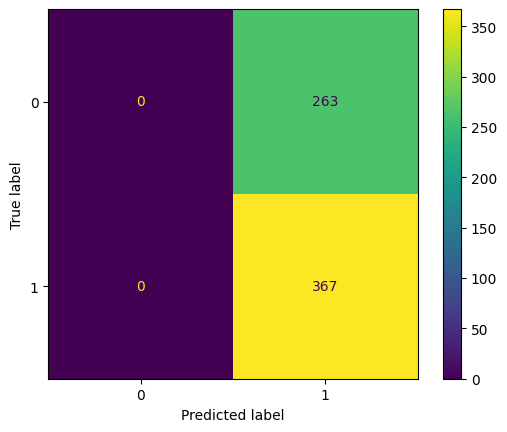

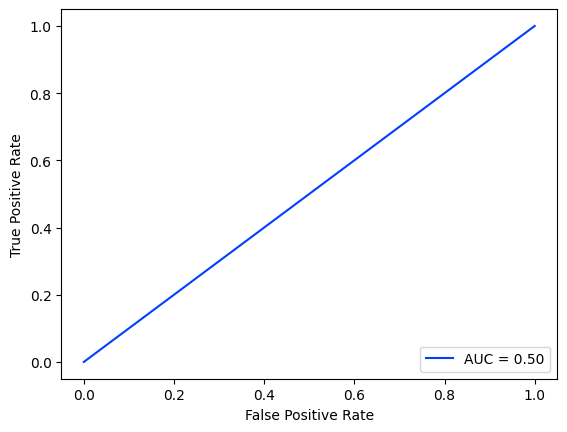

Accuracy: 0.5825396825396826
Recall: 1.0
Precision: 0.5825396825396826
F-1 score: 0.7362086258776329



In [25]:
print("soft margin (γ = 0.0001)")
evaluate(test['root_label_cat'], y_pred_soft, average='binary', clf=svm_soft)

hard margin (γ = 1000)


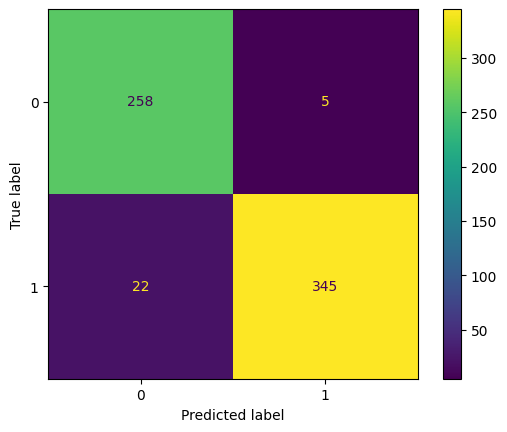

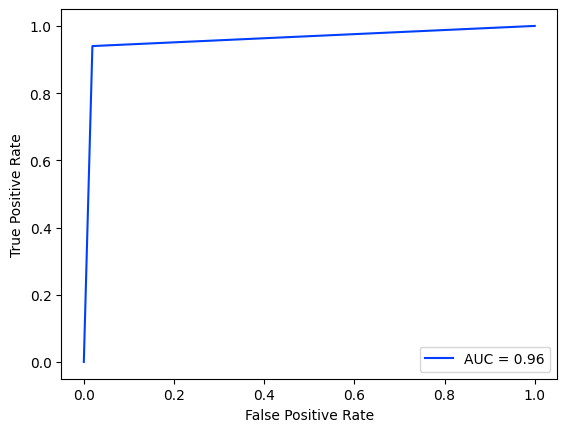

Accuracy: 0.9571428571428572
Recall: 0.9400544959128065
Precision: 0.9857142857142858
F-1 score: 0.9623430962343096



In [26]:
print("hard margin (γ = 1000)")
evaluate(test['root_label_cat'], y_pred_hard, average='binary', clf=svm_hard)

hardest margin (γ = 100000)


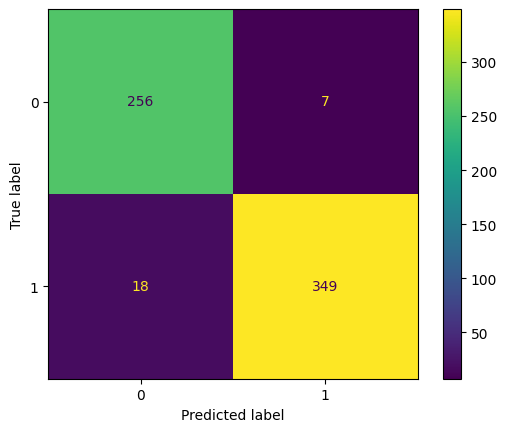

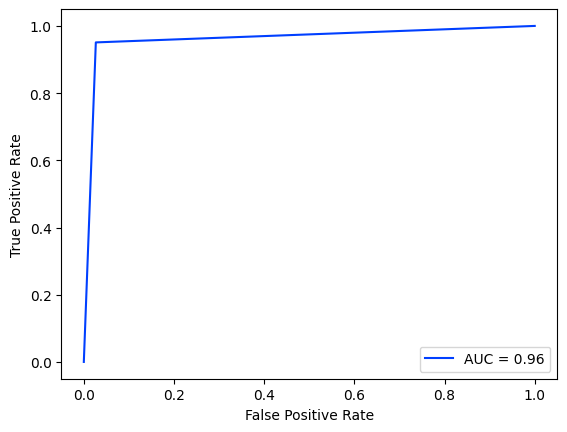

Accuracy: 0.9603174603174603
Recall: 0.9509536784741145
Precision: 0.9803370786516854
F-1 score: 0.9654218533886584



In [27]:
print("hardest margin (γ = 100000)")
evaluate(test['root_label_cat'], y_pred_hard_100000, average='binary', clf=svm_hard_100000)

#### What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.


> Ans:

> The goal of a soft margin support vector machine (SVM) is to allow for some misclassifications in order to classify linearly inseparable classes. This is achieved by allowing for a wider margin, which means that the hinge loss is given less importance and misclassifications are not as heavily penalized. As a result, a soft-margin SVM may have higher recall, but not necessarily high precision. In this case, the margin is too soft so that all predictions are 1, which makes the recall rate be 100%, and the precision be exactly the rate of 1s.


#### Does the ROC curve reflect the performance of the soft-margin SVM? Why?

> Ans:

> Yes. Since all predictions from soft-margin SVM are 1, it literally learns nothing. And the ROC curve for soft-margin SVM has an AUC of 0.5, meaning that the model correctly classifies a random example 50% of the time. This kind of model can be less worthy, since its predictive ability is similar to random guessing.

#### Use cross-validation to choose γ (use average validation accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10^k| − 3 ≤ k ≤ 6,k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

> Ans:

> (1) <br>
C=0.001, average validation accuracy: 0.6738095238095237 <br>
C=0.01, average validation accuracy: 0.9190476190476191 <br>
C=0.1, average validation accuracy: 0.9436507936507936 <br>
C=1, average validation accuracy: 0.9503968253968255 <br>
C=10, average validation accuracy: 0.9503968253968254 <br>
C=100, average validation accuracy: 0.95 <br>
C=1000, average validation accuracy: 0.9484126984126984 <br>
C=10000, average validation accuracy: 0.9146825396825395 <br>
C=100000, average validation accuracy: 0.9277777777777778 <br>
C=1000000, average validation accuracy: 0.9067460317460319 <br>

> When γ=1, the model has the best average validation accuracy.

> (2) Please find the plots and metrics below.

In [28]:
import warnings
warnings.filterwarnings('ignore')

svc = LinearSVC(random_state=SEED)

C_options =  [10**i for i in range(-3, 7)] # − 3 ≤ k ≤ 6
compare_metric = 'accuracy'
params = {'C': C_options}

clf_svc = GridSearchCV(svc, params, cv=5, scoring=compare_metric)
clf_svc.fit(X_train_LSI, train['root_label_cat'])

for c, result in zip(clf_svc.param_grid['C'], clf_svc.cv_results_['mean_test_score']):
    print(f"C={c}, average validation {compare_metric}: {result}")

C=0.001, average validation accuracy: 0.6738095238095237
C=0.01, average validation accuracy: 0.9190476190476191
C=0.1, average validation accuracy: 0.9436507936507936
C=1, average validation accuracy: 0.9503968253968255
C=10, average validation accuracy: 0.9503968253968254
C=100, average validation accuracy: 0.95
C=1000, average validation accuracy: 0.9484126984126984
C=10000, average validation accuracy: 0.9146825396825395
C=100000, average validation accuracy: 0.9277777777777778
C=1000000, average validation accuracy: 0.9067460317460319


best margin (γ = 1)


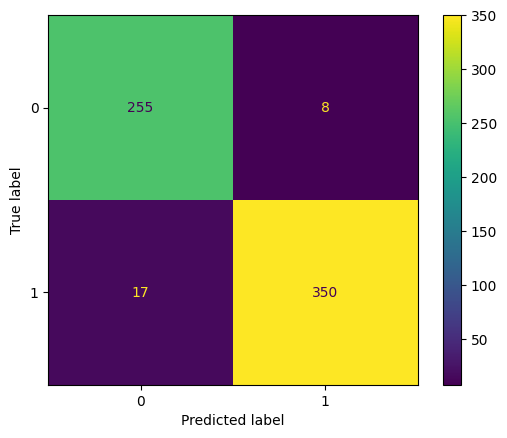

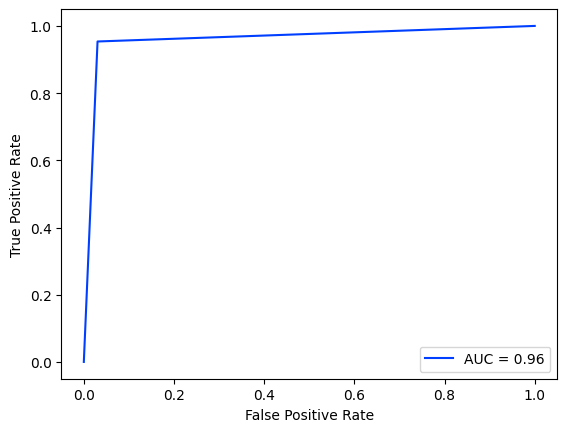

Accuracy: 0.9603174603174603
Recall: 0.9536784741144414
Precision: 0.9776536312849162
F-1 score: 0.9655172413793105



In [29]:
y_pred_best = clf_svc.best_estimator_.predict(X_test_LSI)
print(f"best margin (γ = {clf_svc.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_svc.best_estimator_)

In [30]:
clf_svc.best_score_

0.9503968253968255

### QUESTION 6: Evaluate a logistic classifier

#### Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.

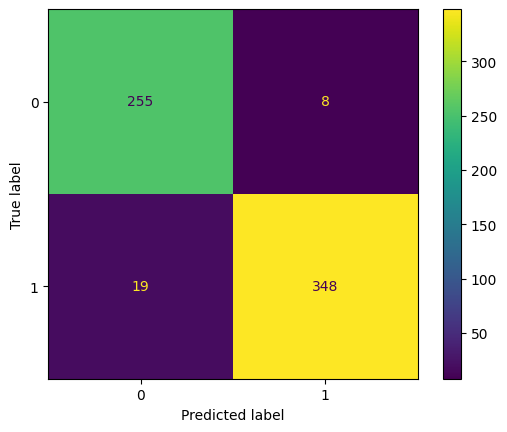

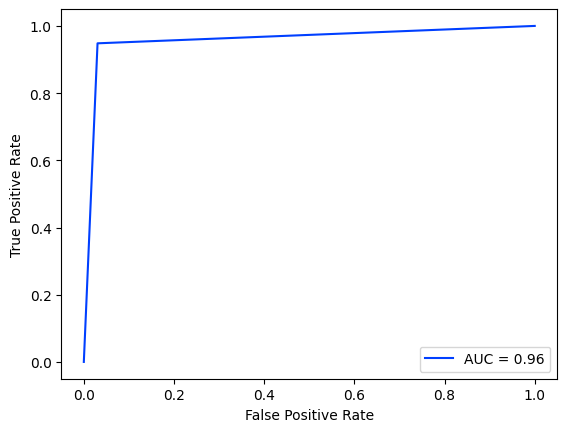

Accuracy: 0.9571428571428572
Recall: 0.9482288828337875
Precision: 0.9775280898876404
F-1 score: 0.9626556016597511



In [31]:
# Reference: https://stackoverflow.com/a/40782844
# In sklearn versions 0.21 and higher, we can disable regularization by passing in penalty='none'. 
lr = LogisticRegression(penalty=None, C=math.inf, random_state=SEED) 
y_pred_lr = lr.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
evaluate(test['root_label_cat'], y_pred_lr, average='binary', clf=lr)

#### Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {$10^k$|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

> Ans: <br>
> With L1 regularization, the optimal validation accuracy is: 0.951984126984127 <br>
> With L2 regularization, the optimal validation accuracy is: 0.951984126984127

In [32]:
lr = LogisticRegression(penalty=None, C=math.inf, random_state=SEED) 
lr_l1 = LogisticRegression(random_state=SEED, penalty='l1', solver='liblinear')
lr_l2 = LogisticRegression(random_state=SEED, penalty='l2', solver='liblinear')

In [33]:
C_options = [10**i for i in range(-5, 6)]  # −5 ≤ k ≤ 5
compare_metric = 'accuracy'
params = {'C': C_options}

clf_lr = GridSearchCV(lr, params, cv=5, scoring=compare_metric)
clf_lr.fit(X_train_LSI, train['root_label_cat'])

for c, result in zip(clf_lr.param_grid['C'], clf_lr.cv_results_['mean_test_score']):
    print(f"C={c}, average validation {compare_metric}: {result}")

C=1e-05, average validation accuracy: 0.9507936507936507
C=0.0001, average validation accuracy: 0.9507936507936507
C=0.001, average validation accuracy: 0.9507936507936507
C=0.01, average validation accuracy: 0.9507936507936507
C=0.1, average validation accuracy: 0.9507936507936507
C=1, average validation accuracy: 0.9507936507936507
C=10, average validation accuracy: 0.9507936507936507
C=100, average validation accuracy: 0.9507936507936507
C=1000, average validation accuracy: 0.9507936507936507
C=10000, average validation accuracy: 0.9507936507936507
C=100000, average validation accuracy: 0.9507936507936507


In [34]:
C_options = [10**i for i in range(-5, 6)]  # −5 ≤ k ≤ 5
compare_metric = 'accuracy'
params = {'C': C_options}

clf_l1 = GridSearchCV(lr_l1, params, cv=5, scoring=compare_metric)
clf_l1.fit(X_train_LSI, train['root_label_cat'])

for c, result in zip(clf_l1.param_grid['C'], clf_l1.cv_results_['mean_test_score']):
    print(f"C={c}, average validation {compare_metric}: {result}")

C=1e-05, average validation accuracy: 0.4511904761904762
C=0.0001, average validation accuracy: 0.4511904761904762
C=0.001, average validation accuracy: 0.4511904761904762
C=0.01, average validation accuracy: 0.4511904761904762
C=0.1, average validation accuracy: 0.9238095238095239
C=1, average validation accuracy: 0.9444444444444444
C=10, average validation accuracy: 0.9519841269841269
C=100, average validation accuracy: 0.9511904761904761
C=1000, average validation accuracy: 0.951984126984127
C=10000, average validation accuracy: 0.951984126984127
C=100000, average validation accuracy: 0.951984126984127


In [35]:
C_options = [10**i for i in range(-5, 6)]  # −5 ≤ k ≤ 5
compare_metric = 'accuracy'
params = {'C': C_options}

clf_l2 = GridSearchCV(lr_l2, params, cv=5, scoring=compare_metric)
clf_l2.fit(X_train_LSI, train['root_label_cat'])

for c, result in zip(clf_l2.param_grid['C'], clf_l2.cv_results_['mean_test_score']):
    print(f"C={c}, average validation {compare_metric}: {result}")

C=1e-05, average validation accuracy: 0.5488095238095239
C=0.0001, average validation accuracy: 0.5488095238095239
C=0.001, average validation accuracy: 0.5488095238095239
C=0.01, average validation accuracy: 0.732936507936508
C=0.1, average validation accuracy: 0.9246031746031746
C=1, average validation accuracy: 0.9444444444444444
C=10, average validation accuracy: 0.9492063492063492
C=100, average validation accuracy: 0.951984126984127
C=1000, average validation accuracy: 0.9511904761904763
C=10000, average validation accuracy: 0.951984126984127
C=100000, average validation accuracy: 0.951984126984127


#### Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.


w/o regularization
best margin (γ = 1e-05)


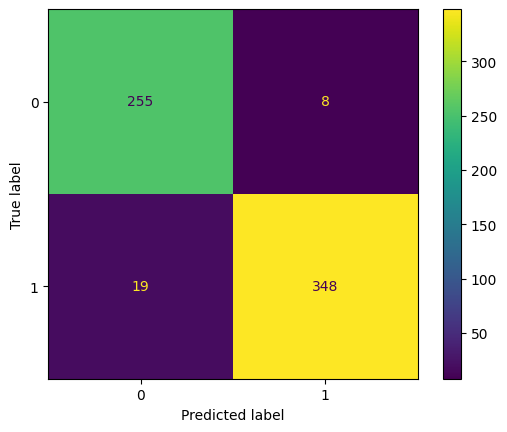

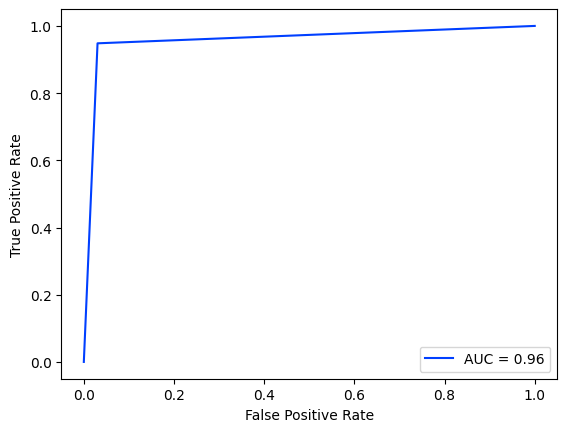

Accuracy: 0.9571428571428572
Recall: 0.9482288828337875
Precision: 0.9775280898876404
F-1 score: 0.9626556016597511



In [36]:
print("w/o regularization")

y_pred_best = clf_lr.best_estimator_.predict(X_test_LSI)
print(f"best margin (γ = {clf_lr.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_lr.best_estimator_)

w/ L1 regularization
best margin (γ = 1000)


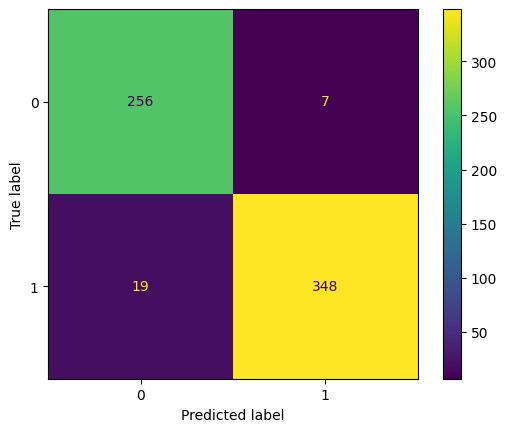

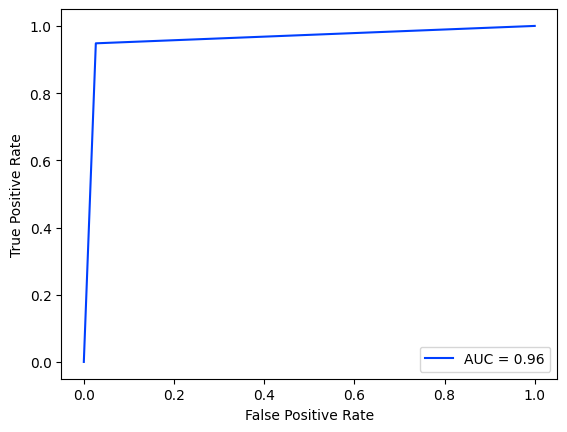

Accuracy: 0.9587301587301588
Recall: 0.9482288828337875
Precision: 0.9802816901408451
F-1 score: 0.96398891966759



In [37]:
print("w/ L1 regularization")

y_pred_best = clf_l1.best_estimator_.predict(X_test_LSI)
print(f"best margin (γ = {clf_l1.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_l1.best_estimator_)

w/ L2 regularization
best margin (γ = 100)


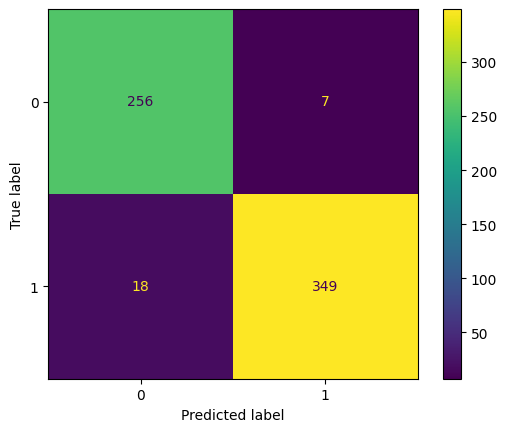

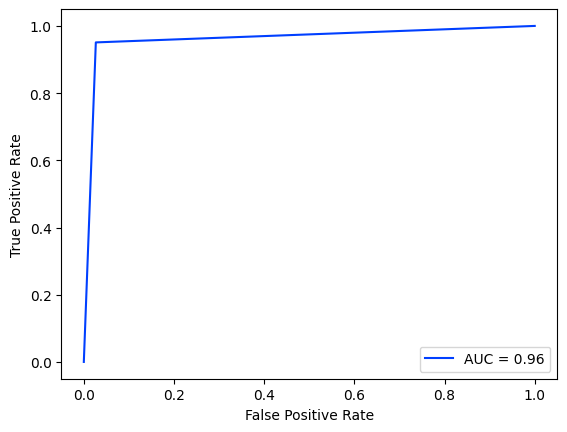

Accuracy: 0.9603174603174603
Recall: 0.9509536784741145
Precision: 0.9803370786516854
F-1 score: 0.9654218533886584



In [38]:
print("w/ L2 regularization")

y_pred_best = clf_l2.best_estimator_.predict(X_test_LSI)
print(f"best margin (γ = {clf_l2.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_l2.best_estimator_)

#### How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

> Ans: <br>

> <b> w/ L2 regularization: </b> <br>
L2 regularization can mitigate the multicollinearity problem by restricting the size of the coefficients and keeping all variables. Unlike L1 regularization, L2 regularization is less likely to produce coefficients of value 0, which can be an advantage or disadvantage depending on the specific use case. The learned coefficients in L2 regularization are generally smaller than those in logistic regression without regularization. This type of regularization is beneficial for ensuring that the model is not overly reliant on a small number of features, making it less sensitive to small changes in the feature vectors, resulting in a more robust model.


> <b> w/ L1 regularization: </b> <br>
Some of the learned coefficients are 0 and most of the learned coefficients are on the order of magnitude which is smaller than the learned coefficients of logistic regression without any regularization. This type of regularization is useful when someone wants to build a sparse model by removing features. This results in a process called feature selection which keeps the most significant features in the model. L1 regularization can address the multicollinearity problem by constraining the coefficient norm and pinning some coefficient values to 0. Computationally, Lasso regression (regression with an L1 penalty) is a quadratic program which requires special tools to solve. When you have more features than observations 𝑁, Lasso will keep at most 𝑁 non-zero coefficients. Depending on the context, this might not be what you want. L1 regularization is sometimes used as a feature selection method. Suppose you have some kind of hard cap on the number of features you can use (because data collection for all features is expensive, or you have tight engineering constraints on how many values you can store, etc.). You can try to tune the L1 penalty to hit your desired number of non-zero features.


> <b> w/o regularization: </b> <br>
When not using regularization, the model's coefficients tend to be large, making the model unstable and prone to overfitting. However, this type of regularization can be beneficial when constructing a complex model for handling complex data, and there are no indications of overfitting.





#### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

> Ans: <br>

> (1)
Logistic Regression is a classification model that is used to predict the odds of a particular event occurring. It uses the sigmoid function to convert input values into a probability between 0 and 1, and it tries to maximize the conditional likelihood of the training data. It is sensitive to outliers and requires standardization to ensure that the features' weights do not dominate over others. It is a probabilistic method that focuses on maximizing the likelihood of correct classification on the entire training set, by providing probability scores for each class. It produces a decision boundary based on the input data. On the other hand, Support Vector Machine (SVM) is a powerful classification algorithm that maximizes the margin among class variables by finding the decision boundary that separates the positive and negative samples. The goal is to have a large margin for the decision boundary to adjust bias-variance proportion. SVM is less sensitive to outliers as it only cares about the points closest to the decision boundary, and it can adapt its decision boundary depending on new positive or negative events. It is a deterministic method that uses a subset of points closest to the decision boundary (support vectors) to find an optimal separating hyperplane that maximizes the distance of the vectors to the margin. This results in a decision boundary that reduces the misclassification rate.


> (2) From the performances perspective, Logistic Regression provides high confidence in classifying data further away from the hyperplane but is less effective for samples near the margin. SVM is more efficient and faster at handling complex, high-dimensional and unstructured data through the kernel trick, while Logistic Regression is more suitable for structured datasets. Logistic Regression is more prone to overfitting as its decision is based on observations on the entire training set, whereas Support Vector Machine (SVM) provides better generalization by using a subset of points closest to the decision boundary (support vectors). That is why the performances differ and SVMs often more accurate than logistic regression in general.

> (3) No, the difference is not statistically significant from the above experiments.

Reference to: https://www.geeksforgeeks.org/differentiate-between-support-vector-machine-and-logistic-regression/


### QUESTION 7: Evaluate and profile a Naïve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

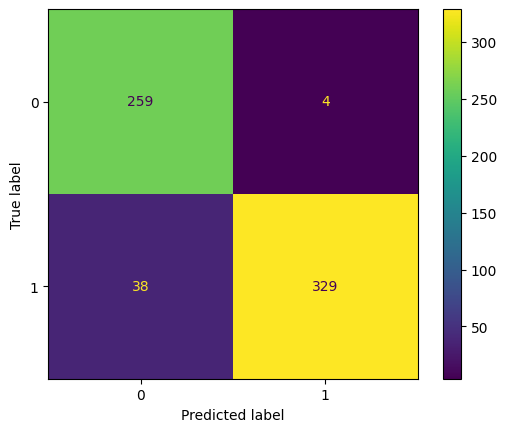

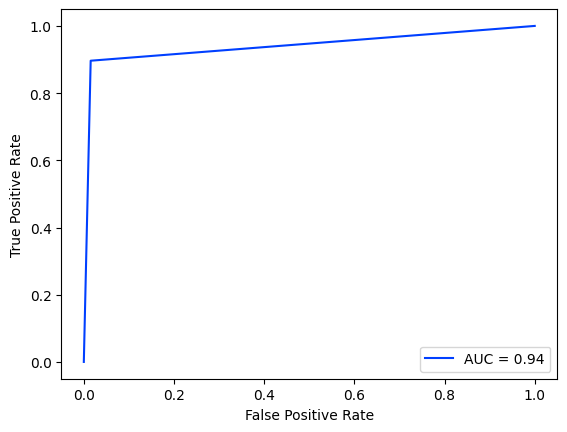

Accuracy: 0.9333333333333333
Recall: 0.896457765667575
Precision: 0.987987987987988
F-1 score: 0.9400000000000001



In [39]:
nb = GaussianNB() 
y_pred_lr = nb.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
evaluate(test['root_label_cat'], y_pred_lr, average='binary', clf=nb)

### QUESTION 8: In this part, you will attempt to find the best model for binary classification.
- Construct a Pipeline that performs feature extraction, dimensionality reduction and classification;
- The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).
- In addition to any other hyperparameters you choose, your gridsearch must at least include: 

    - min df = 3 vs 5
    - use Lemmatization vs Stemming 
    - LSI (k = [5, 30, 80]) vs NMF (k = [5, 30, 80])
    - SVM with the best γ previously found
    - Logistic Regression: L1 regularization vs L2 regularization, with the best regularization strength previously found
    - GaussianNB

In [40]:
%%time
text_columns = ["full_text_lemma", "full_text_stem"]
text_col2method_name = {
    "full_text_lemma": "lemmatization",
    "full_text_stem": "stemming",
}

cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=0)

# save best results
best_estimator = None
best_score = 0
best_params = None
results = []


def append_preprocess_method(x, text_column):
    """Append preprocessing method by the used text column."""
    x["preprocess"] = text_col2method_name[text_column]
    return x


# iterate difference kinds of preprocessed text
for text_column in text_columns:
    pipe = Pipeline([('count', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('dim_reduce', TruncatedSVD(random_state=SEED)),
                     ('classify', GaussianNB()),
                    ],
                   memory=memory,
                   )

    params = {
        # min df = 3 vs 5
        'count__min_df': (3, 5),
        'dim_reduce': (
            TruncatedSVD(random_state=SEED),
            NMF(init='random', random_state=SEED)
        ),
        # LSI (k = [5, 30, 80]) vs NMF (k = [5, 30, 80])
        'dim_reduce__n_components': (5, 30, 80),
        'classify': (
            LinearSVC(C=clf_svc.best_estimator_.C, random_state=SEED), # SVM
            LogisticRegression(
                penalty='l1',
                C=clf_l1.best_estimator_.C,
                random_state=SEED,
                solver='liblinear',
            ), # LR L1
            LogisticRegression(
                penalty='l2',
                C=clf_l2.best_estimator_.C,
                random_state=SEED,
                solver='liblinear',
            ), # LR L2
            GaussianNB(),  # GNB
        ),
    }
    
    # grid search on 2*2*3*4 = 48 combinations
    clf_grid = GridSearchCV(pipe, cv=5, n_jobs=24, param_grid=params, scoring='accuracy')
    clf_grid.fit(train[text_column], train['root_label_cat'])
    
    # append results
    result = pd.DataFrame(clf_grid.cv_results_)[['params', 'mean_test_score']]
    result.params = result.params.apply(lambda x: append_preprocess_method(x, text_column))
    results.append(result)
    
    # update overall best model
    if clf_grid.best_score_ > best_score:
        best_score = clf_grid.best_score_
        best_estimator = clf_grid.best_estimator_
        best_params = clf_grid.best_params_
        best_params["preprocess"] = text_col2method_name[text_column]


/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/ray080186/.pyenv/versions/3.9.0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum nu

CPU times: user 55.4 s, sys: 22 s, total: 1min 17s
Wall time: 3min 37s


In [41]:
best_params

{'classify': LogisticRegression(C=1000, penalty='l1', random_state=42, solver='liblinear'),
 'count__min_df': 3,
 'dim_reduce': NMF(init='random', n_components=80, random_state=42),
 'dim_reduce__n_components': 80,
 'preprocess': 'stemming'}

In [42]:
best_score

0.9607142857142856

In [43]:
best_estimator

Pipeline(memory=Memory(location=/tmp/tmpdn_o9fgo/joblib),
         steps=[('count', CountVectorizer(min_df=3, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('dim_reduce',
                 NMF(init='random', n_components=80, random_state=42)),
                ('classify',
                 LogisticRegression(C=1000, penalty='l1', random_state=42,
                                    solver='liblinear'))])

best parameters {'classify': LogisticRegression(C=1000, penalty='l1', random_state=42, solver='liblinear'), 'count__min_df': 3, 'dim_reduce': NMF(init='random', n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'stemming'})


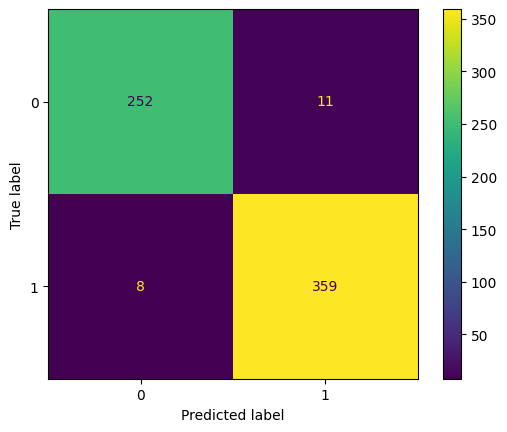

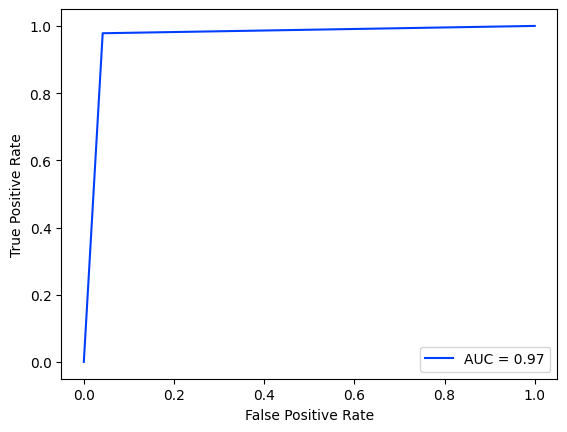

Accuracy: 0.9698412698412698
Recall: 0.9782016348773842
Precision: 0.9702702702702702
F-1 score: 0.9742198100407056



In [44]:
y_pred_best = best_estimator.predict(test["full_text"])
print(f"best parameters {clf_grid.best_params_})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_grid.best_estimator_)

#### What are the 5 best combinations? Report their performances on the testing set.
> Ans: The best 5 combinations and their corresponding performances are shown below.

In [45]:
results = pd.concat(results)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
for i, (params, acc) in enumerate(results[:5][['params', 'mean_test_score']].values):
    print(f"{i+1}:\n  - params={params}\n  - test accuracy={acc}\n")

1:
  - params={'classify': LogisticRegression(C=1000, penalty='l1', random_state=42, solver='liblinear'), 'count__min_df': 3, 'dim_reduce': NMF(init='random', n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'stemming'}
  - test accuracy=0.9607142857142856

2:
  - params={'classify': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'lemmatization'}
  - test accuracy=0.9587301587301587

3:
  - params={'classify': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'count__min_df': 3, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'lemmatization'}
  - test accuracy=0.9583333333333334

4:
  - params={'classify': LinearSVC(C=1, random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(random_state=42), 'dim_reduce__n_components': 80, 'prep

### QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.

#### Perform Naïve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

> Ans: There are many ways to resolve the imblalance issue. One of them is to use the class_weight='balanced' in scikit-learn LinearSVC.

> The scikit-learn library for Python includes an implementation of the Support Vector Machine (SVM) algorithm that includes the option for class weighting. The LinearSVC offers a class_weight parameter, which can be specified as a model hyperparameter. This parameter is a dictionary that assigns different weights to each class label which can be used to adjust the C value in the calculation of the soft margin. When applied, class weighting can improve the performance of the SVM algorithm when dealing with imbalanced datasets by giving more importance to the minority class.

In [46]:
def evaluate_mul(y_test, y_pred, average=None, clf=None):
    print("=" * 20)
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=clf.classes_)
    cm_display.plot()
    plt.show()
    
    print(f"Accuracy: {accuracy_score(y_test,y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred, average=None)}")
    print(f"Precision: {precision_score(y_test, y_pred, average=None)}")
    print(f"F-1 score: {f1_score(y_test, y_pred, average=None)}")
    print("=" * 20)
    print()


In [47]:
train_mul, test_mul = train_test_split(data, test_size=0.2)

map_row_to_class = {"chess": 0, "cricket": 1, "hockey": 2, "soccer": 3,
                    "football": 4, "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7,
                    "drought": 8}

train_mul['leaf_label_cat'] = train_mul.leaf_label.map(map_row_to_class)
test_mul['leaf_label_cat'] = test_mul.leaf_label.map(map_row_to_class)

In [48]:
pipe = Pipeline([
    ('count', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer())])

# train
X_train_mul = pipe.fit_transform(train_mul["full_text_lemma"])

# test
X_test_mul = pipe.transform(test_mul["full_text_lemma"])

nmf_model = NMF(init='random', n_components=80, random_state=SEED)
X_train_NMF_mul = nmf_model.fit_transform(X_train_mul) 
X_test_NMF_mul = nmf_model.transform(X_test_mul) 

#### In the confusion matrix you should have an 9 × 9 matrix where 9 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:

#### Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

> Ans: 
> (1) Yes, it is 9x9 and each number corrsponding to each leaf label. 
```
 map_row_to_class = {"chess": 0, "cricket": 1, "hockey": 2, "soccer": 3,
                    "football": 4, "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7,
                    "drought": 8}
```
> (2) Yes, except soccer and football are not that well classified. <br>
> (3) If there is visible blocks on the major diagonal, it means the data has been correctly classified.

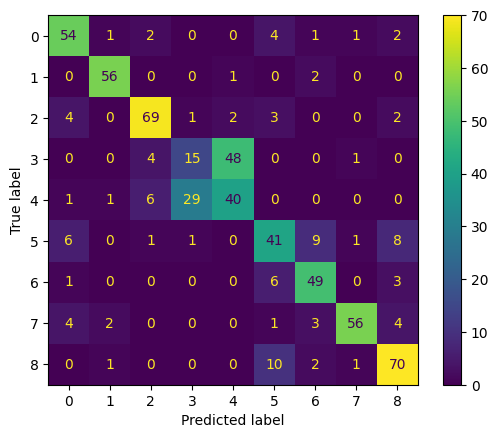

Accuracy: 0.7142857142857143
Recall: [0.83076923 0.94915254 0.85185185 0.22058824 0.51948052 0.6119403
 0.83050847 0.8        0.83333333]
Precision: [0.77142857 0.91803279 0.84146341 0.32608696 0.43956044 0.63076923
 0.74242424 0.93333333 0.78651685]
F-1 score: [0.8        0.93333333 0.84662577 0.26315789 0.47619048 0.62121212
 0.784      0.86153846 0.80924855]



In [49]:
nb = GaussianNB() 
y_pred_nb = nb.fit(X_train_NMF_mul, train_mul['leaf_label_cat']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat'], y_pred_nb, average=None, clf=nb)

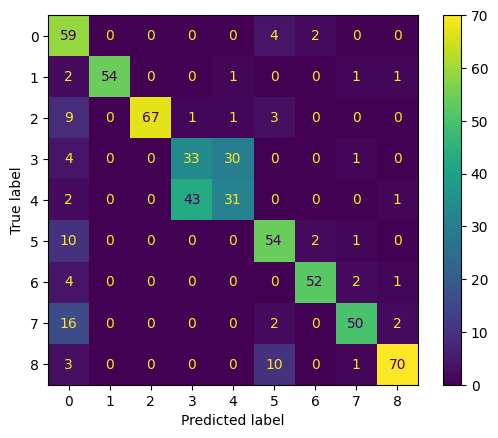

Accuracy: 0.746031746031746
Recall: [0.90769231 0.91525424 0.82716049 0.48529412 0.4025974  0.80597015
 0.88135593 0.71428571 0.83333333]
Precision: [0.5412844  1.         1.         0.42857143 0.49206349 0.73972603
 0.92857143 0.89285714 0.93333333]
F-1 score: [0.67816092 0.95575221 0.90540541 0.45517241 0.44285714 0.77142857
 0.90434783 0.79365079 0.88050314]



In [50]:
one_one_svm = OneVsOneClassifier(LinearSVC(random_state=SEED))
y_pred_one_one = one_one_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat'], y_pred_one_one, average=None, clf=one_one_svm)

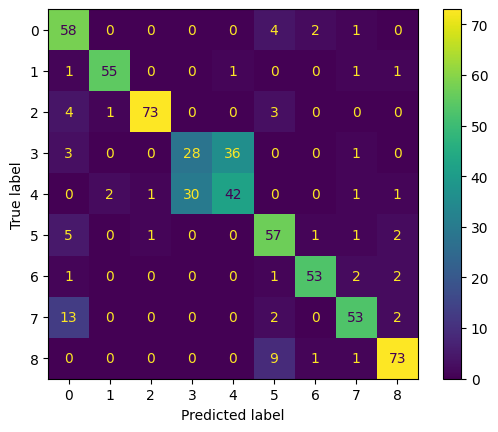

Accuracy: 0.780952380952381
Recall: [0.89230769 0.93220339 0.90123457 0.41176471 0.54545455 0.85074627
 0.89830508 0.75714286 0.86904762]
Precision: [0.68235294 0.94827586 0.97333333 0.48275862 0.53164557 0.75
 0.92982456 0.86885246 0.90123457]
F-1 score: [0.77333333 0.94017094 0.93589744 0.44444444 0.53846154 0.7972028
 0.9137931  0.80916031 0.88484848]



In [51]:
one_all_svm = OneVsRestClassifier(LinearSVC(random_state=SEED))
y_pred_one_all = one_all_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat'], y_pred_one_all, average=None, clf=one_all_svm)

#### Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

> Ans: It would be more appropriate if soccer and football be merged into a new larger label. Please find the plots and metric below.

> One VS One 
Accuracy: 0.746031746031746 -> 0.8047619047619048 (after merged)

> One VS the rest
Accuracy: 0.780952380952381 -> 0.8698412698412699 (after merged)


In [52]:
map_row_to_class_merged = {"chess": 0, "cricket": 1, "hockey": 2, "soccer": 3,
                    "football": 3, "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7,
                    "drought": 8}

train_mul['leaf_label_cat_merged'] = train_mul.leaf_label.map(map_row_to_class_merged)
test_mul['leaf_label_cat_merged'] = test_mul.leaf_label.map(map_row_to_class_merged)

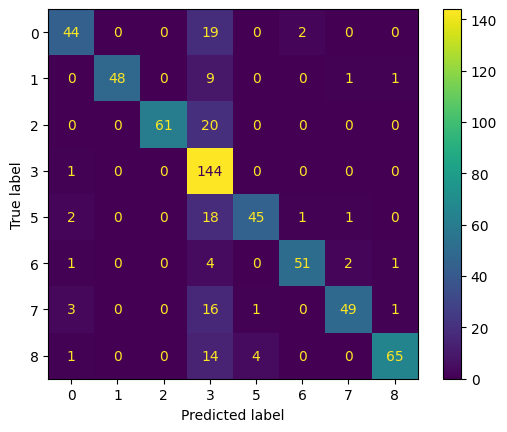

Accuracy: 0.8047619047619048
Recall: [0.67692308 0.81355932 0.75308642 0.99310345 0.67164179 0.86440678
 0.7        0.77380952]
Precision: [0.84615385 1.         1.         0.59016393 0.9        0.94444444
 0.9245283  0.95588235]
F-1 score: [0.75213675 0.89719626 0.85915493 0.7403599  0.76923077 0.90265487
 0.79674797 0.85526316]



In [53]:
one_one_svm = OneVsOneClassifier(LinearSVC(random_state=SEED))
y_pred_one_one = one_one_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat_merged']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat_merged'], y_pred_one_one, average=None, clf=one_one_svm)

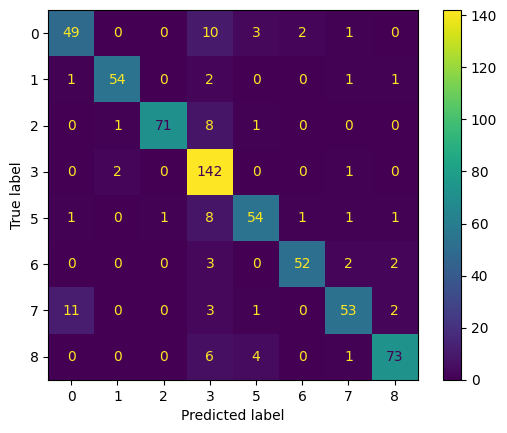

Accuracy: 0.8698412698412699
Recall: [0.75384615 0.91525424 0.87654321 0.97931034 0.80597015 0.88135593
 0.75714286 0.86904762]
Precision: [0.79032258 0.94736842 0.98611111 0.78021978 0.85714286 0.94545455
 0.88333333 0.92405063]
F-1 score: [0.77165354 0.93103448 0.92810458 0.86850153 0.83076923 0.9122807
 0.81538462 0.89570552]



In [54]:
one_all_svm = OneVsRestClassifier(LinearSVC(random_state=SEED))
y_pred_one_all = one_all_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat_merged']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat_merged'], y_pred_one_all, average=None, clf=one_all_svm)

#### Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.

> Ans: As mentioned above, there are many ways to resolve the imblalance issue. One of them is to use the class_weight='balanced' in scikit-learn LinearSVC.

> The scikit-learn library for Python includes an implementation of the Support Vector Machine (SVM) algorithm that includes the option for class weighting. The LinearSVC offers a class_weight parameter, which can be specified as a model hyperparameter. This parameter is a dictionary that assigns different weights to each class label which can be used to adjust the C value in the calculation of the soft margin. When applied, class weighting can improve the performance of the SVM algorithm when dealing with imbalanced datasets by giving more importance to the minority class.

> One VS One 
Accuracy: 0.746031746031746 -> 0.8047619047619048 (after merged) -> 0.8650793650793651 (after dealing with imbalanced)

> One VS the rest
Accuracy: Accuracy: 0.780952380952381 -> 0.8698412698412699 (after merged) -> 0.8825396825396825 (after dealing with imbalanced)


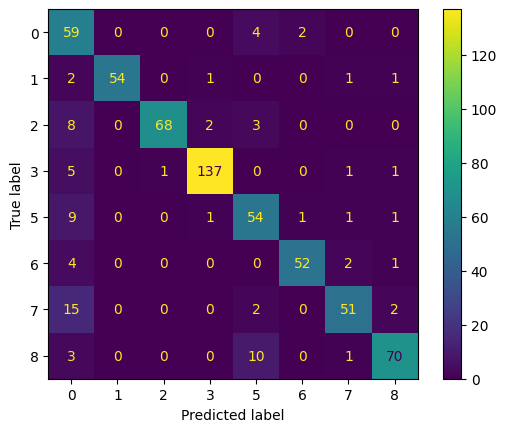

Accuracy: 0.8650793650793651
Recall: [0.90769231 0.91525424 0.83950617 0.94482759 0.80597015 0.88135593
 0.72857143 0.83333333]
Precision: [0.56190476 1.         0.98550725 0.97163121 0.73972603 0.94545455
 0.89473684 0.92105263]
F-1 score: [0.69411765 0.95575221 0.90666667 0.95804196 0.77142857 0.9122807
 0.80314961 0.875     ]



In [55]:
one_one_svm = OneVsOneClassifier(LinearSVC(random_state=SEED, class_weight='balanced'))
y_pred_one_one = one_one_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat_merged']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat_merged'], y_pred_one_one, average=None, clf=one_one_svm)

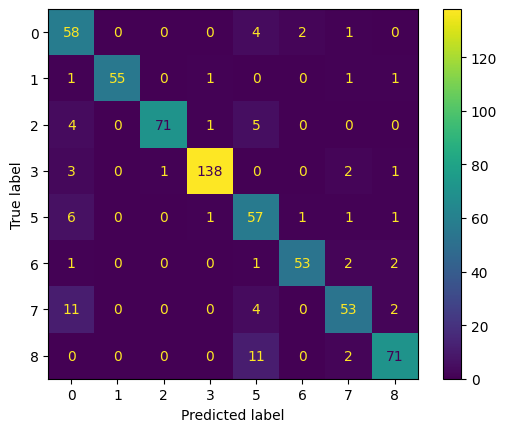

Accuracy: 0.8825396825396825
Recall: [0.89230769 0.93220339 0.87654321 0.95172414 0.85074627 0.89830508
 0.75714286 0.8452381 ]
Precision: [0.69047619 1.         0.98611111 0.9787234  0.69512195 0.94642857
 0.85483871 0.91025641]
F-1 score: [0.77852349 0.96491228 0.92810458 0.96503497 0.76510067 0.92173913
 0.8030303  0.87654321]



In [56]:
one_all_svm = OneVsRestClassifier(LinearSVC(random_state=SEED, class_weight='balanced'))
y_pred_one_all = one_all_svm.fit(X_train_NMF_mul, train_mul['leaf_label_cat_merged']).predict(X_test_NMF_mul)
evaluate_mul(test_mul['leaf_label_cat_merged'], y_pred_one_all, average=None, clf=one_all_svm)

### QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:


#### (a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

> Ans: <br>

> GLoVe embeddings are trained on the ratio of co-occurrence probabilities instead of the probabilities themselves in order to make them less affected by the inherent biases of the corpus. The co-occurrence probability of two words is calculated as the number of times they appear together in a context window, divided by the total number of words in the corpus. However, this measure can be influenced by the size of the corpus and the distribution of words within it.

> By taking the ratio of the co-occurrence probabilities, the GLoVe model can adjust for these biases and provide a more accurate representation of the relationship between words. This allows the model to overcome the limitations of using raw co-occurrence probabilities and gives a more robust and stable representation of words. Additionally, the ratio of co-occurrence probabilities also has a useful interpretation in terms of the Pointwise Mutual Information which is a measure of association between two words.

> In summary, GLoVe embeddings are trained on the ratio of co-occurrence probabilities instead of the probabilities themselves to overcome the limitations of using raw co-occurrence probabilities and to provide a more robust and stable representation of words, which is less affected by the inherent bias of the corpus.

#### (b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

> Ans: GLoVe embeddings are trained on the ratio of co-occurrence probabilities of words in a corpus, which takes into account the context in which the words appear. This means that the vector for "running" will be different when it appears in the context of "presidency" compared to when it appears in the context of "park", for example. The model uses conditional probability ratios to represent relationships with different words, this way it captures the context in which the word appears and the relationship with other words.



#### (c) What do you expect for the values of, ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2, ||GLoVE["queen"] - GLoVE["king"]||2 and ||GLoVE["wife"] - GLoVE["husband"]||2 ? Compare these values.


> Ans: I expect ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2 should be close to zero and ||GLoVE["queen"] - GLoVE["king"]||2  should be close to ||GLoVE["wife"] - GLoVE["husband"]||2.
 
> The value of ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2 represents the difference in the vector representation of the words "queen" and "king" subtracted by the difference in the vector representation of the words "wife" and "husband". It can be expected that this value will be relatively low, as the difference between the vector representations of "queen" and "king" is likely to be similar to the difference between the vector representations of "wife" and "husband", as they are all pairs of words with related meaning.

> On the other hand, the value of ||GLoVE["queen"] - GLoVE["king"]||2 represents the difference between the vector representation of the words "queen" and "king" and it can be expected to be relatively low as well, as both words are related to royalty and marriage has a similar meaning.

> ||GLoVE["wife"] - GLoVE["husband"]||2 represents the difference between the vector representation of the words "wife" and "husband" and it could be expected to be low as well, as both words are related to marriage and have a similar meaning.

> I expect that the first value, ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2, will be smaller than the second and the third values, ||GLoVE["queen"] - GLoVE["king"]||2, and ||GLoVE["wife"] - GLoVE["husband"]||2 respectively, because it's comparing the difference between the words "queen" and "king" with the difference between the words "wife" and "husband" .




In [57]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [58]:
embed_queen = embeddings_dict["queen"]
embed_king = embeddings_dict["king"]
embed_wife = embeddings_dict["wife"]
embed_husband = embeddings_dict["husband"]

print(f'||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2: {np.linalg.norm(embed_queen - embed_king - embed_wife + embed_husband)}')
print(f'||GLoVE["queen"] - GLoVE["king"]||2: {np.linalg.norm(embed_queen - embed_king)}')
print(f'||GLoVE["wife"] - GLoVE["husband"]||2: {np.linalg.norm(embed_wife - embed_husband)}')

||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2: 6.165036678314209
||GLoVE["queen"] - GLoVE["king"]||2: 5.9662580490112305
||GLoVE["wife"] - GLoVE["husband"]||2: 3.1520464420318604


#### (d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

> I would rather use Lemmatization.

> As mentioned above, Lemmatization uses a dictionary-based approach and takes into account the context and part of speech of a word to determine its lemma, or base form. This method is more accurate but also more computationally expensive. On the other hand, stemming uses a rule-based approach to remove suffixes from a word, which is less accurate but less computationally expensive.

> Further, I think Lemmatization doesn't change the cluster output significantly because the word vectors for similar words will be very close, regardless of the word's grammatical form. This is because the GLoVe embeddings capture the underlying meaning of a word, rather than its surface form. Therefore, similar words will have similar vectors, regardless of their grammatical form.

Reference: https://www.linkedin.com/pulse/unsupervised-learning-glove-word-embeddings-search-queries-bhandari

### QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:

#### (a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document. You have to abide by the following rules:
- A representation of a text segment needs to have a vector dimension that CANNOT exceed the dimension of the GLoVE embedding used per word of the segment.
- You cannot use TF-IDF scores (or any measure that requires looking at the complete dataset) as a pre-processing routine.
- Important: In this section, feel free to use raw features from any column in the original data file not just full text. The column keywords might be useful... or not.
- To aggregate these words into a single vector consider normalization the vectors, averaging across the vectors.

> Ans: First, the raw text will go through the same text-cleaning process as above. Then, tokens which can be found in GLoVE pre-trained embeddings will be vectorized. Finally, all token embeddings will be normalized and the document embedding will be the mean of embeddings of tokens.

In [59]:
class GloveVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings_dict, dim):
        self.embeddings_dict = embeddings_dict
        self.dim = dim

    def fit(self, X):
        return self

    def transform(self, X):
        data = np.zeros((len(X), self.dim))
        n = 0
        for sentence in X:
            tokens = sentence.split()
            vecs = []
            for word in tokens:
                vec = embeddings_dict.get(word, None)
                if vec is not None:
                    vecs.append(vec)
            if len(vecs) > 0:
                vecs = preprocessing.normalize(vecs) # # To aggregate these words into a single vector consider normalization the vectors, 
                data[n] = [sum(col) / float(len(col)) for col in zip(*vecs)] # averaging across the vectors.
            n += 1
        return data  
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Reference to: 
# https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Applying-the-word-embedding-to-a-text-classification-task

In [60]:
vectorizer = GloveVectorTransformer(embeddings_dict, 300)

X_train_glove = vectorizer.fit_transform(train["full_text_lemma"])
X_test_glove = vectorizer.transform(test["full_text_lemma"])

print(X_train_glove.shape, X_test_glove.shape)

(2520, 300) (630, 300)


#### (b) Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing any cross-validation, please make sure to use a limited set of options so that your code finishes running in a reasonable amount of time.

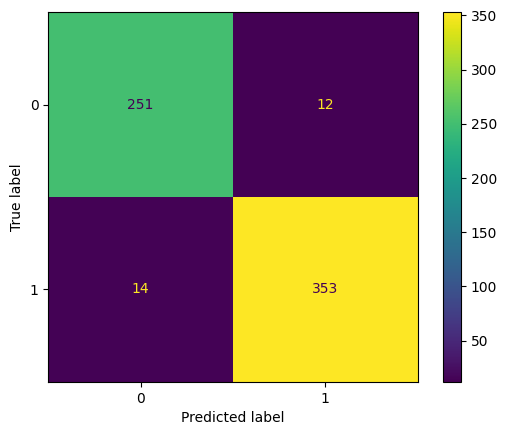

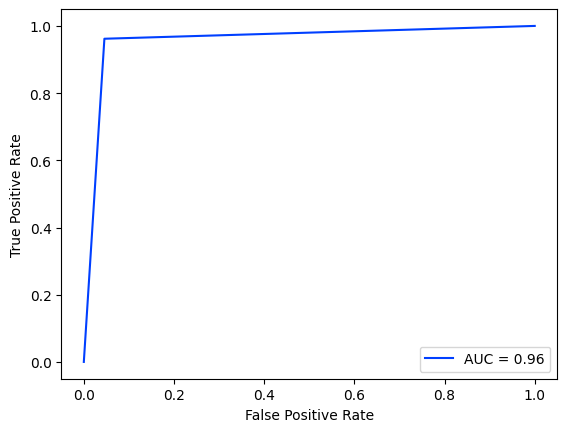

Accuracy: 0.9587301587301588
Recall: 0.9618528610354223
Precision: 0.9671232876712329
F-1 score: 0.9644808743169399



In [61]:
clf_glove = LinearSVC(C=100, random_state=SEED)
clf_glove.fit(X_train_glove, train['root_label_cat'])
y_pred_glove = clf_glove.predict(X_test_glove)
evaluate(test['root_label_cat'], y_pred_glove, average='binary', clf=clf_glove)

### QUESTION 12: Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.

> Ans: <br>
> As the dimension increases, the accuracy also increases. <br>
> Yes, the trend is expected because more dimensions should remain much more semantic and complex information in general, leading to better accuracy.

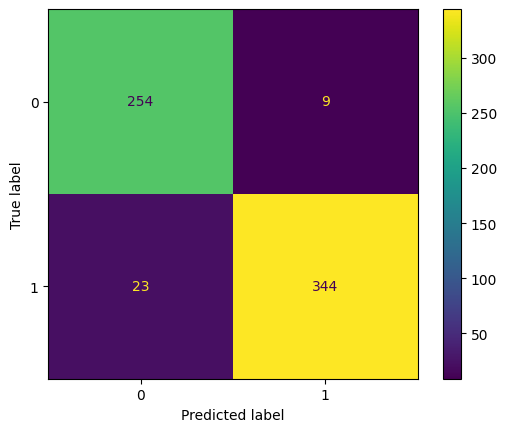

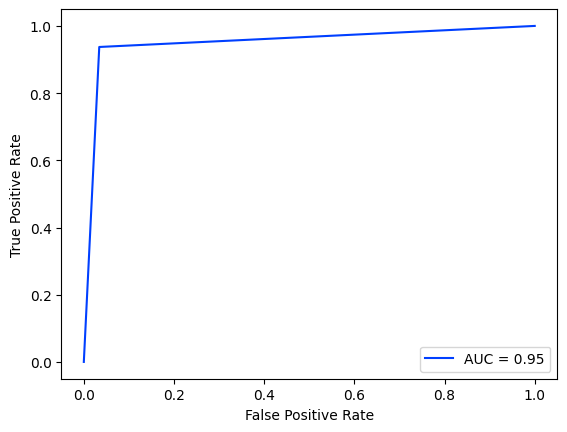

Accuracy: 0.9492063492063492
Recall: 0.9373297002724795
Precision: 0.9745042492917847
F-1 score: 0.9555555555555556



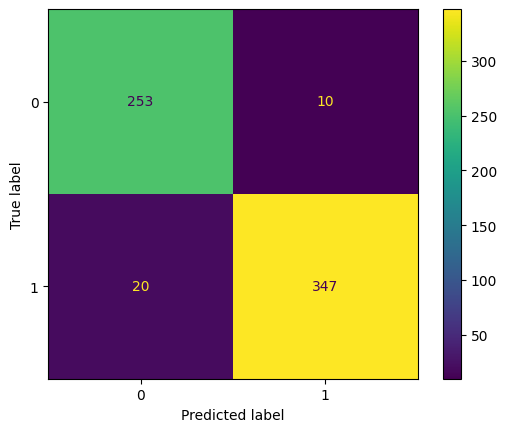

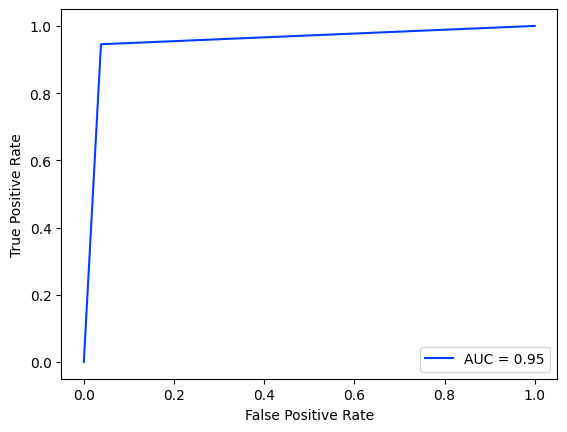

Accuracy: 0.9523809523809523
Recall: 0.9455040871934605
Precision: 0.9719887955182073
F-1 score: 0.9585635359116021



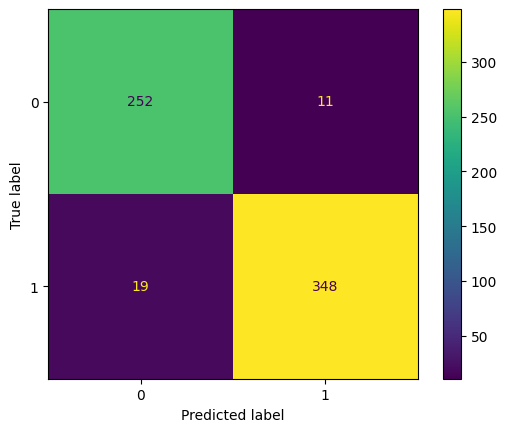

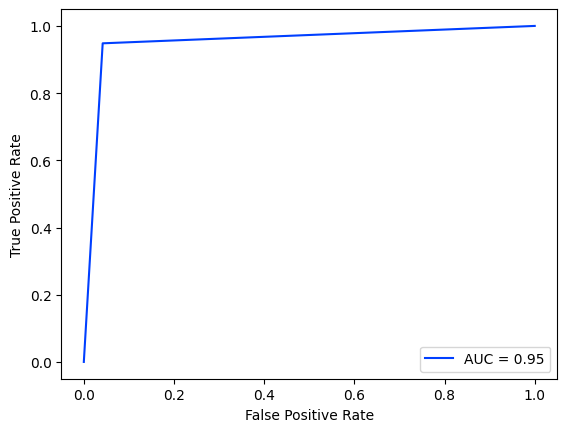

Accuracy: 0.9523809523809523
Recall: 0.9482288828337875
Precision: 0.9693593314763231
F-1 score: 0.9586776859504132



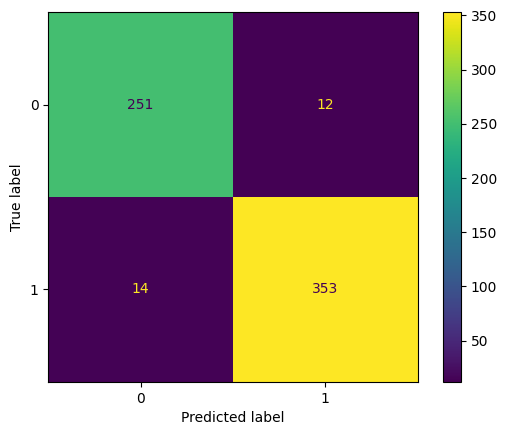

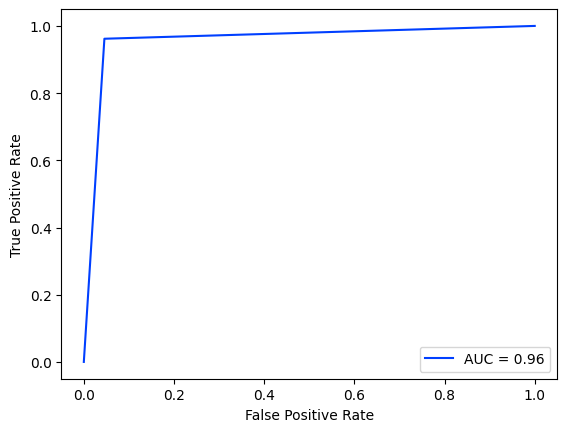

Accuracy: 0.9587301587301588
Recall: 0.9618528610354223
Precision: 0.9671232876712329
F-1 score: 0.9644808743169399



In [62]:
dim_options = [50, 100, 200, 300]
accuracy_glove = []

for dim in dim_options:
    embeddings_dict = {}
    dimension_of_glove = dim
    with open(f"glove.6B/glove.6B.{dim}d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    vectorizer = GloveVectorTransformer(embeddings_dict, dim)

    X_train_glove = vectorizer.fit_transform(train["full_text_lemma"])
    X_test_glove = vectorizer.transform(test["full_text_lemma"])

    clf_glove = LinearSVC(C=100, random_state=SEED)
    clf_glove.fit(X_train_glove, train['root_label_cat'])
    y_pred_glove = clf_glove.predict(X_test_glove)
    evaluate(test['root_label_cat'], y_pred_glove, average='binary', clf=clf_glove)
    accuracy_glove.append(accuracy_score(test['root_label_cat'], y_pred_glove))
    

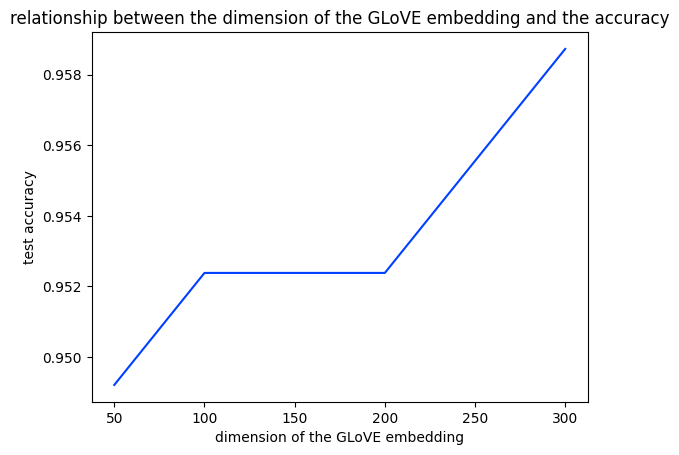

In [63]:
plt.plot(dim_options, accuracy_glove)
plt.title('relationship between the dimension of the GLoVE embedding and the accuracy')
plt.xlabel('dimension of the GLoVE embedding')
plt.ylabel('test accuracy')
plt.show()

### QUESTION 13: Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

> Ans: Yes, we see clear cluster in the figure entititled with "normalized GLoVE-based embeddings with their binary labels in a 2D plane" but not the one generated by the normalized random vector embeddings.

> This suggests that the GLoVE embeddings are effectively capturing the semantic relationships between words in the actual dataset, allowing for clear distinctions between different classes. The lack of clustering in the randomly generated points further supports this interpretation.

Text(0.5, 1.0, 'normalized GLoVE-based embeddings with their binary labels in a 2D plane')

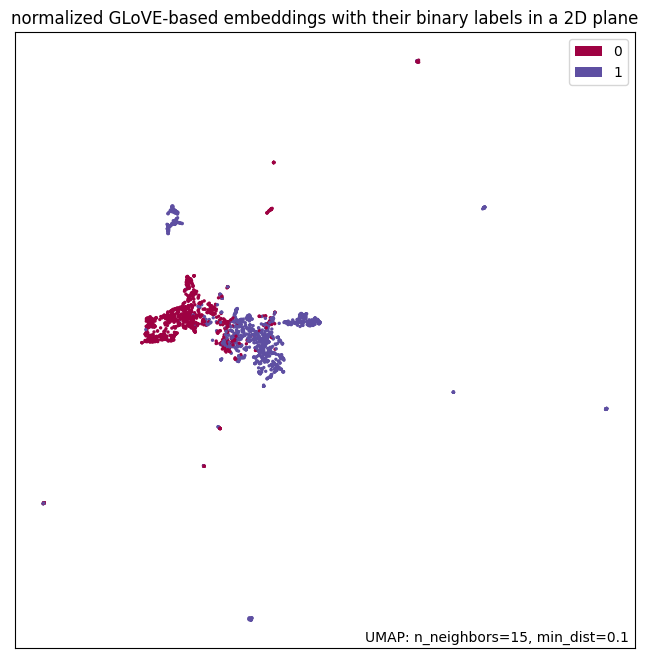

In [64]:
umap_glove_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_glove)
umap_glove_plot = umap.plot.points(umap_glove_embedding, labels=train['root_label_cat'])
plt.title('normalized GLoVE-based embeddings with their binary labels in a 2D plane')


# Reference to:
# https://umap-learn.readthedocs.io/en/latest/document_embedding.html
# https://github.com/lmcinnes/umap/issues/828

Text(0.5, 1.0, 'normalized random vector embeddings in a 2D plane')

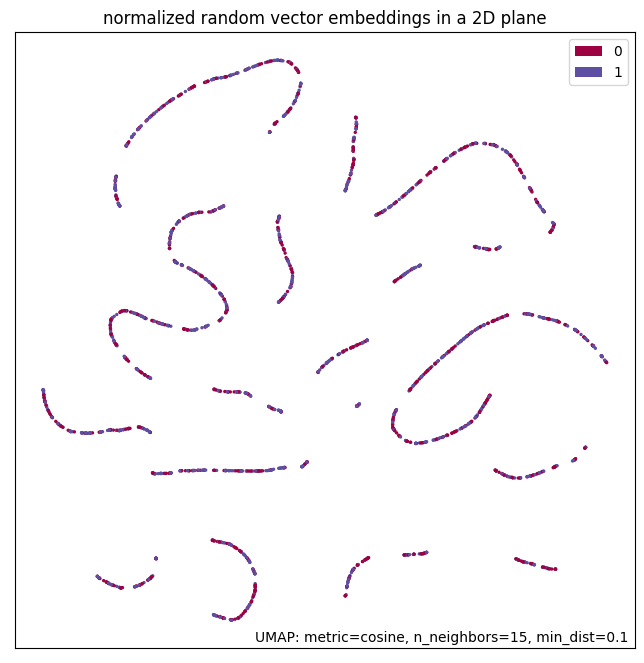

In [65]:
random_vec = np.random.normal(0, 1, umap_glove_embedding.embedding_.shape)
random_vec = preprocessing.normalize(random_vec)


umap_random_embedding = umap.UMAP(n_components=2, metric='cosine').fit(random_vec)
umap_random_plot = umap.plot.points(umap_random_embedding, labels=train['root_label_cat'])
plt.title('normalized random vector embeddings in a 2D plane')
